# This is a Neural network version template for classification. <br>
You may simply change the loss functions to transfer it to regression model, as well as the activation function before output.<br>



In [109]:

import numpy as np
import datetime
import pandas as pd
import lightgbm as lgb

from tensorflow import keras
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import skopt
# !pip install scikit-optimize if  necessary
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

import boto3, os


pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
s3 = boto3.resource('s3')
layers = keras.layers

# data loading

In [110]:
data = np.random.rand(10000,31)
df = pd.DataFrame(data,columns = ['f'+str(i) for i in range(1,32)])
df['f31'] = df['f31'].apply(round)

df.loc[:7000,'f1'] = '2019-01-01'
df.loc[7000:,'f1'] = '2020-01-01'


#f2 is supposed to be some 
df['f2'] = df['f2'].apply(lambda x:int(100*x))
df['f3'] = df['f3'].apply(lambda x:int(80*x))

# data cleansing

In [111]:

def data_cleansing(df):
    
    #df = df[conditions]     
    
    df = df.fillna(0)
    
    return df

print('clean data')
df_cleansed = data_cleansing(df)    

clean data



# data processing

In [112]:
dummy_features = []
date_features = ['f1']
norm_features = []
# normally we don't have to normalize data in boosting tree methods


def data_processing(df):
    
    if len(dummy_features) != 0:
        for feature in dummy_features:
            dummy = pd.get_dummies(df[feature],prefix=feature)
            df = pd.concat([df,dummy],axis=1)
        df = df.drop(columns = dummy_features)


    if len(date_features) != 0:
        for feature in date_features:
            df[feature+'_dayofweek'] = pd.to_datetime(df[feature]).dt.dayofweek
    
    #normally, normalization is subtle, not just compute mean and std of the whole dataset,
    #it may be different in different dataset. 
    
    #if len(norm_features) != 0:
        
    return df


print('process data')
df_processed = data_processing(df_cleansed)



process data


# data split

In [113]:
features = ['f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21',
       'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30','f1_dayofweek']
label = 'f31'
split_date = '2020-01-01'

def data_split(df,features,label,split_date):
    
    X_train = df[df['f1']<split_date][features].reset_index(drop=True)
    y_train = df[df['f1']<split_date][label].reset_index(drop=True)
    
    X_test = df[df['f1']>=split_date][features].reset_index(drop=True)
    y_test = df[df['f1']>=split_date][label].reset_index(drop=True)
    
    return X_train,y_train,X_test,y_test


X_train,y_train,X_test,y_test = data_split(df_processed,features,label,split_date)

# Features

Normally, we have these kinds of features.<br>
Temporal features includes both trend features and seasonal features. <br>
Embedding features are those with IDs, like user_id, ad_id and site_ad.<br>
wide features are some attributes of each sample.

In [ ]:
# temporal features, history data in a consecutive period ago 
trend_features = ['f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21',]
# temporal features, history data in every period time 
seasonal_features = ['f7', 'f14', 'f21', 'f28',]
# some attribute features
wide_features = ['f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f1_dayofweek',]
# some ids, should be embedding first
embedding_features = ['f2','f3']

label = 'f31'

# Here are popular base blocks.

Normally dense block will be the last part of the neural network . <br>
If you want to unveil the mystery of time series, you may use a Dilated convolution after the input layer but before the LSTM layers. <br>
And of course, you may use any combination of these blocks.

NOTE:

'num_output' means a single value you need to input. <br>
'num_outputs' means you need to feed in a list which includes several values. <br>

In [63]:
def LSTM_Block(Input,num_output):

    if len(Input.shape)!= 3:
        Output = layers.Reshape((Input.shape[1],1))(Input)
    else:
        Output = Input
    Output = layers.LSTM(num_output,)(Output)
    return Output

def Dense_Block(Input,num_outputs):
    Output = Input
    for i in range(len(num_outputs)):
        if i == len(num_outputs):
#             activation = 'sigmoid'
            activation = 'relu'
        else:
            activation = 'relu'
        Output = layers.Dense(num_outputs[i],activation=activation)(Output)
    return Output


def DilatedConv_Block(Input,num_channels,kernel_size=2):
    if len(Input.shape)!= 3:
        Output = layers.Reshape((Input.shape[1],1))(Input)
    else:
        Output = Input
    for i in range(len(num_channels)):
        dilation_rate = 2 ** i
        Output = layers.Conv1D(
                num_channels[i],
                kernel_size,
                padding='causal',
                dilation_rate=dilation_rate,
                activation='relu')(Output)
    if num_channels[-1]>1:
        Output = layers.Dense(1)(Output)
    Output = layers.Flatten()(Output)
    return Output

def SimpleConv_Block(Input,filters,kernel_size=2):
    if len(Input.shape)!= 3:
        Output = layers.Reshape((Input.shape[1],1))(Input)
    else:
        Output = Input
    Output = layers.Conv1D(filters,kernel_size)(Output)
    if filters>1:
        Output = layers.Dense(1)(Output)
    Output = layers.Flatten()(Output)
       
    return Output
    
def Embedding_block(Input,input_dim,output_dim):
    Output = layers.Embedding(input_dim,output_dim,)(Input)
    Output = layers.Reshape(target_shape=(output_dim,))(Output) 
    
    return Output
    

# You may use any combination of these blocks! Here is an example!

In [64]:
num_channels = [1,2,3]
dense_outputs = [10,1]
lstm_output = 10
input_dim = 1000
output_dim = 10
trend_input  = layers.Input(shape=len(trend_features),name='trend_input')
trend_output = DilatedConv_Block(trend_input,num_channels)
trend_output = SimpleConv_Block(trend_output,2)
trend_output = LSTM_Block(trend_output,lstm_output)
trend_output = SimpleConv_Block(trend_output,2)
trend_output = DilatedConv_Block(trend_input,num_channels)
trend_output = Embedding_block(trend_output,input_dim,output_dim)
trend_output = Dense_Block(trend_output,dense_outputs)
trend_output = DilatedConv_Block(trend_input,num_channels)
trend_output = LSTM_Block(trend_output,lstm_output)
trend_output = Embedding_block(trend_output,input_dim,output_dim)
model = keras.Model(inputs=trend_input,outputs=trend_output)
model.compile(loss='mae',optimizers=keras.optimizers.Adam(lr=0.01))
model.summary()


Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trend_input (InputLayer)     [(None, 18)]              0         
_________________________________________________________________
reshape_93 (Reshape)         (None, 18, 1)             0         
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 18, 1)             3         
_________________________________________________________________
conv1d_106 (Conv1D)          (None, 18, 2)             6         
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 18, 3)             15        
_________________________________________________________________
dense_97 (Dense)             (None, 18, 1)             4         
_________________________________________________________________
flatten_43 (Flatten)         (None, 18)                0  

# An example of classification that combine all of these features.

You can change or even delete any of these models, depends on your need. <br>
Just note that the model sub models are, the model parameters you need to tune. <br>

In [114]:

def build_trend_model(num_channels,lstm_output,dense_outputs):
   
    #trend model
    trend_input  = layers.Input(shape=len(trend_features),name='trend_input')
    trend_output = DilatedConv_Block(trend_input,num_channels)
    trend_output = LSTM_Block(trend_output,lstm_output)
    trend_output = Dense_Block(trend_output,dense_outputs)
    
    model = keras.Model(inputs=trend_input,outputs=trend_output)
    model.compile(loss=Loss,optimizers=adam)
    return model

def build_seasonal_model(num_channels,lstm_output,dense_outputs):
    #seasonal model
    seasonal_input  = layers.Input(shape=len(seasonal_features),name='seasonal_input')
    seasonal_output = DilatedConv_Block(seasonal_input,num_channels)
    seasonal_output = LSTM_Block(seasonal_output,lstm_output)
    seasonal_output = Dense_Block(seasonal_output,dense_outputs)

    model = keras.Model(inputs=seasonal_input,outputs=seasonal_output)
    model.compile(loss=Loss,optimizers=adam)
    return model

def build_wide_model(dense_outputs):
    wide_input  = layers.Input(shape=len(wide_features),name='wide_input')
    
    wide_output = Dense_Block(wide_input,dense_outputs)
    model = keras.Model(inputs=wide_input,outputs=wide_output)
    model.compile(loss=Loss,optimizers=adam)
    
    return model


def build_wide_model_with_embeddings(dense_outputs,output_dims):
    
    wide_input = layers.Input(shape=len(wide_features),name='wide_input')
    embedding_inputs = []
    embedding_outputs = []
    
    for i,feature in enumerate(embedding_features):
        embedding_input = layers.Input(shape=(1,),name=feature)
        input_dim = df[feature].nunique() + 1
        embedding_output = Embedding_block(embedding_input,input_dim,output_dims[i])
        embedding_inputs.append(embedding_input)
        embedding_outputs.append(embedding_output)

    combine_output = layers.concatenate([wide_input]+embedding_outputs)

    combine_output = Dense_Block(combine_output,dense_outputs)
    model = keras.Model(inputs=[wide_input]+embedding_inputs,outputs=combine_output)
    model.compile(loss=Loss,optimizers=adam)
    
    return model    


In [115]:
def merge_model(trend_model,seasonal_model,wide_model):
    
    merged_output = layers.concatenate([seasonal_model.output,trend_model.output,wide_model.output,])
    merged_output = layers.Dense(1,activation='sigmoid')(merged_output)
    merged_model = keras.Model([trend_model.input] + [seasonal_model.input] + [wide_model.input], merged_output)
    merged_model.compile(loss=Loss, optimizer=adam)
    
    return merged_model 
    

In [116]:
def train_model(model,X_train,y_train,X_test,y_test,
                    TRAINING_EPOCH=3,BATCH_SIZE=128,PLOT=False):    
    
    start_time = datetime.datetime.now()
    history = model.fit(
                    X_train,y_train,
                    epochs=TRAINING_EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test,y_test)
                       )
    end_time = datetime.datetime.now()
    run_time = (end_time - start_time).seconds
    print("Model fitting runs for {run_time} seconds for {epoch} epochs.".format(run_time=run_time, epoch=TRAINING_EPOCH))
    if PLOT==True:
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    return model



In [117]:


X_train_trend,y_train,X_test_trend,y_test = data_split(df_processed,trend_features,label,split_date)
X_train_seasonal,y_train,X_test_seasonal,y_test = data_split(df_processed,seasonal_features,label,split_date)
X_train_wide,y_train,X_test_wide,y_test = data_split(df_processed,wide_features,label,split_date)

# you may eliminate embeddings
X_train_embeddings = []
X_test_embeddings = []

for feature in embedding_features:
    X_train_embedding,y_train,X_test_embedding,y_test = data_split(df_processed,[feature],label,split_date)
    X_train_embeddings.append(X_train_embedding)
    X_test_embeddings.append(X_test_embedding)
    
X_train = [X_train_trend] + [X_train_seasonal] + [X_train_wide] + X_train_embeddings
X_test = [X_test_trend] + [X_test_seasonal] + [X_test_wide] + X_test_embeddings




In [118]:
adam = keras.optimizers.Adam(lr=0.001)
Loss = 'binary_crossentropy'

trend_model = build_trend_model([1,10,1],5,[1])
seasonal_model = build_seasonal_model([1,10,1],5,[1])
wide_model = build_wide_model([10,1])
wide_model_with_embeddings = build_wide_model_with_embeddings([10,5,1],[10,5])

model = merge_model(trend_model,seasonal_model,wide_model_with_embeddings)
model.summary()

Model: "model_80"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seasonal_input (InputLayer)     [(None, 4)]          0                                            
__________________________________________________________________________________________________
trend_input (InputLayer)        [(None, 18)]         0                                            
__________________________________________________________________________________________________
reshape_136 (Reshape)           (None, 4, 1)         0           seasonal_input[0][0]             
__________________________________________________________________________________________________
reshape_134 (Reshape)           (None, 18, 1)        0           trend_input[0][0]                
___________________________________________________________________________________________

in case you can't plot model, try these 3 methods by order.<br>

method one:<br>
pip install pydot-ng<br>
pip install graphviz<br>
pip install pydot==1.2.3<br>

method two:<br>
brew install graphviz<br>

method three:<br>
'from tensorflow.keras.utils import plot_model' instead of 
'from keras.utils.vis_utils import plot_model'
    

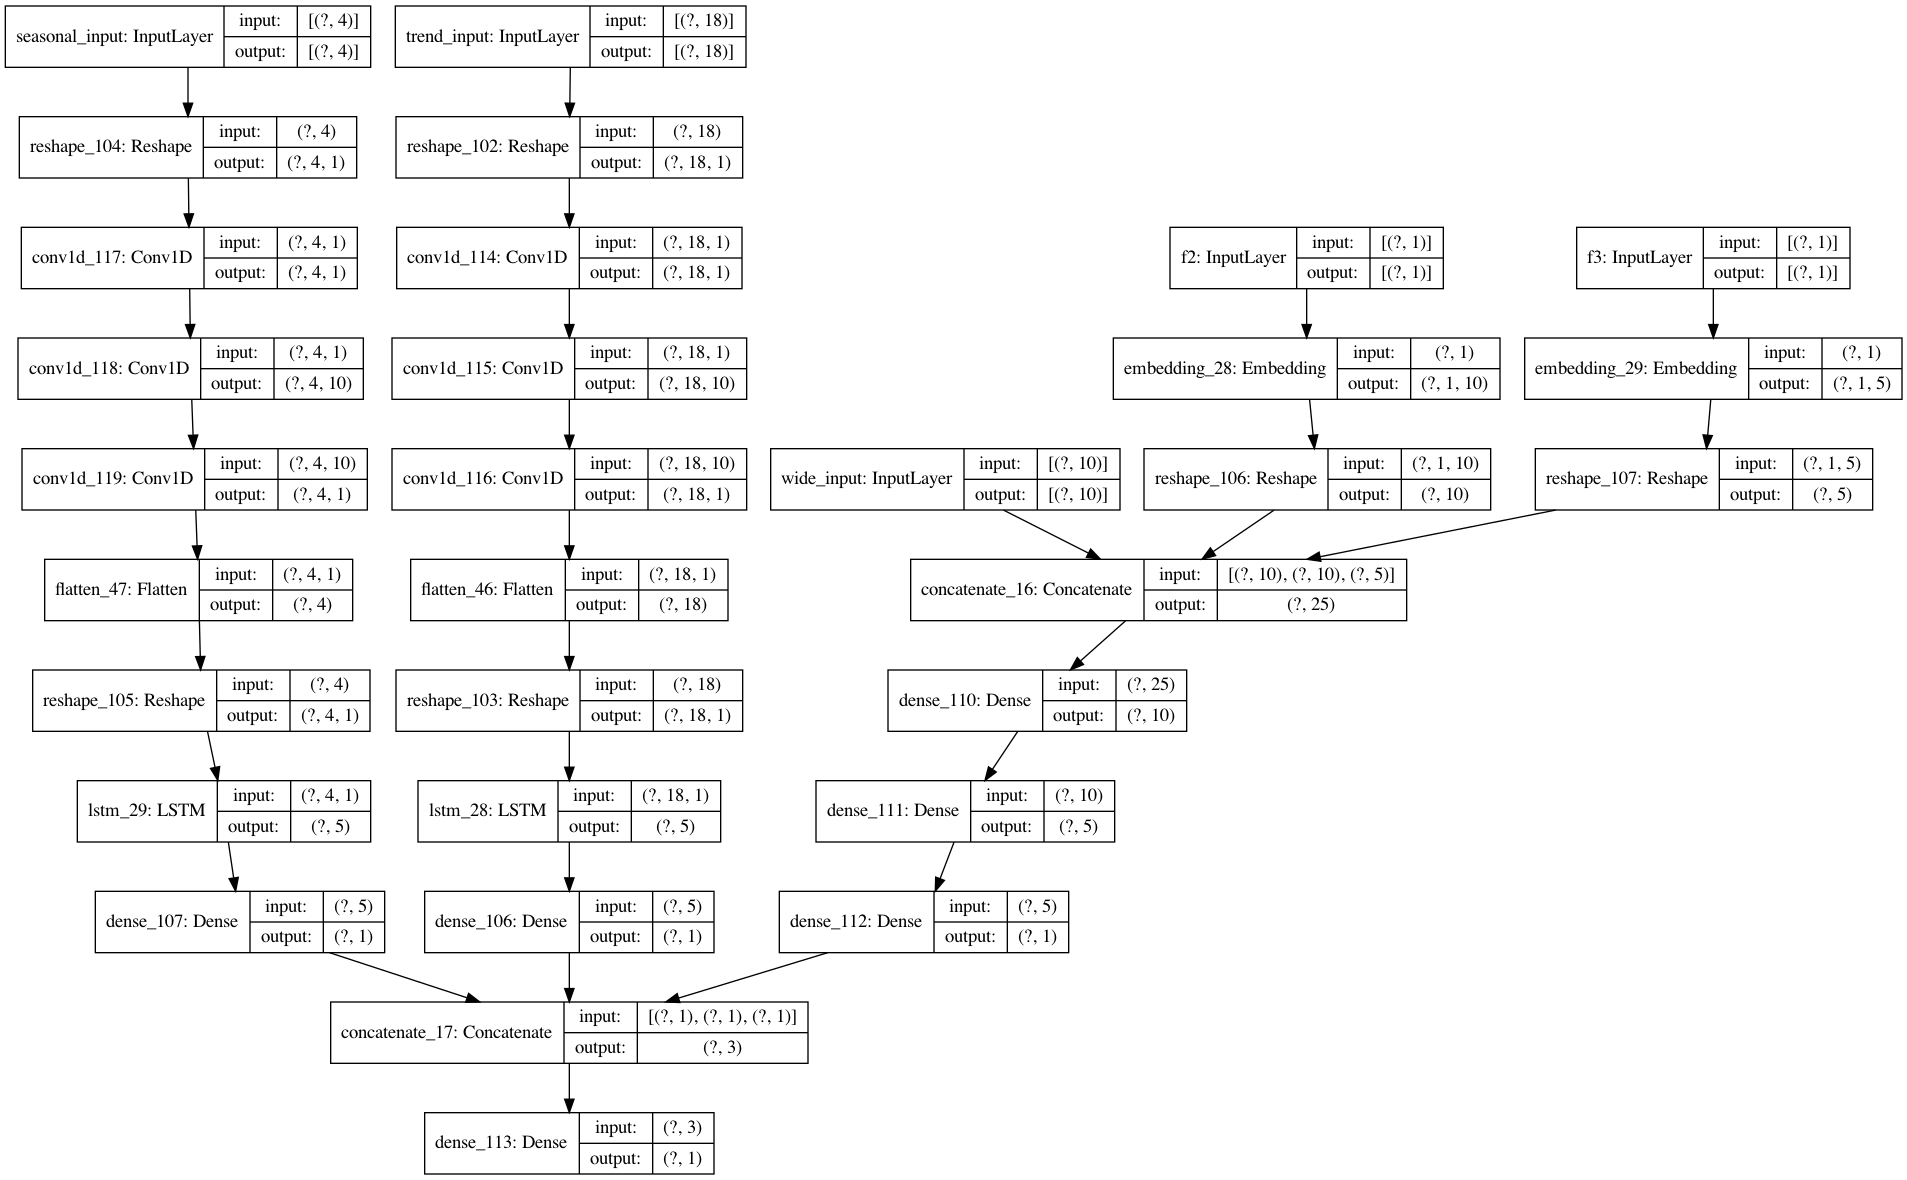

In [78]:

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [79]:
model = train_model(model,X_train,y_train,X_test,y_test,
                    TRAINING_EPOCH=10,BATCH_SIZE=128,PLOT=False)
y_pred = model.predict(X_test).reshape(-1)

Train on 7000 samples, validate on 3000 samples
Epoch 1/10
7000/7000 [==============================] - 2s 277us/sample - loss: 0.6936 - val_loss: 0.6930
Epoch 2/10
7000/7000 [==============================] - 1s 94us/sample - loss: 0.6930 - val_loss: 0.6930
Epoch 3/10
7000/7000 [==============================] - 1s 97us/sample - loss: 0.6928 - val_loss: 0.6931
Epoch 4/10
7000/7000 [==============================] - 1s 98us/sample - loss: 0.6923 - val_loss: 0.6930
Epoch 5/10
7000/7000 [==============================] - 1s 94us/sample - loss: 0.6916 - val_loss: 0.6932
Epoch 6/10
7000/7000 [==============================] - 1s 107us/sample - loss: 0.6903 - val_loss: 0.6934
Epoch 7/10
7000/7000 [==============================] - 1s 95us/sample - loss: 0.6882 - val_loss: 0.6935
Epoch 8/10
7000/7000 [==============================] - 1s 101us/sample - loss: 0.6858 - val_loss: 0.6946
Epoch 9/10
7000/7000 [==============================] - 1s 97us/sample - loss: 0.6830 - val_loss: 0.6954
Epoc

In [80]:
y_pred

array([0.4705486 , 0.48993427, 0.4890663 , ..., 0.5436513 , 0.5375607 ,
       0.5329287 ], dtype=float32)

# Evaluation

In [81]:
def plot_roc_curve(fpr,tpr,roc_auc):    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

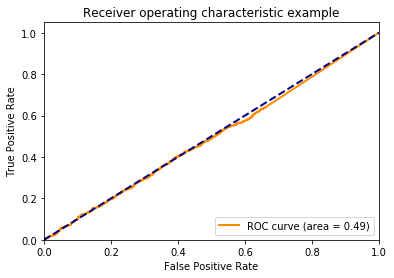

0.4927247962822936

In [82]:
def evaluate_model(y_test,y_pred,PLOT=True):

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    if PLOT:
        plot_roc_curve(fpr,tpr,roc_auc)
    return roc_auc

AUC = evaluate_model(y_test,y_pred)
AUC

In [85]:
def PrecisionRecall(y_test,y_pred,threshold):
   
    y_pred = pd.DataFrame(y_pred,columns=['pred'])
    y_pred = y_pred['pred'].apply(lambda x: 1 if x>=threshold else 0)
    tp = pd.concat([y_test,y_pred],axis=1)
    tp.columns = ['true','pred']
    precision = tp[(tp['pred']==1)&(tp['true']==1)].shape[0]/tp[tp['pred']==1].shape[0]
    recall = tp[(tp['pred']==1)&(tp['true']==1)].shape[0]/tp[tp['true']==1].shape[0]
    return round(precision,4),round(recall,4)
Precision,Recall = PrecisionRecall(y_test,y_pred,0.5)
Precision,Recall

(0.5092, 0.4017)

# Custom loss function

binary focal loss

In [90]:
import keras.backend as K


# alpha1,alpha2 ∈ (0, 1), gamma1,gamma2 ∈ [2, 5]
def binary_focal_loss(alpha1,alpha2,gamma1,gamma2):
    
    def custom_loss(y_true,y_pred):
        y_true = K.cast(y_true, dtype='float32')
        y_pred = K.cast(y_pred, dtype='float32')
        
        first  = -alpha1 * y_true * K.pow(1-y_pred,gamma1) * K.log(y_pred)
        second = -alpha2 * (1-y_true) * K.pow(y_pred,gamma2) * K.log(1-y_pred)
    
        loss = K.sum(first+second)
        return loss
    return custom_loss
    
    

In [97]:
adam = keras.optimizers.Adam(lr=0.001)
alpha1 = 0.4
alpha2 = 0.6
gamma1 = 1
gamma2 = 2

Loss = binary_focal_loss(alpha1,alpha2,gamma1,gamma2)

trend_model = build_trend_model([1,10,1],5,[1])
seasonal_model = build_seasonal_model([1,10,1],5,[1])
wide_model = build_wide_model([10,1])
wide_model_with_embeddings = build_wide_model_with_embeddings([10,5,1],[10,5])

model = merge_model(trend_model,seasonal_model,wide_model_with_embeddings)
# model.summary()

Train on 7000 samples, validate on 3000 samples
Epoch 1/10
7000/7000 [==============================] - 1s 100us/sample - loss: 15.2639 - val_loss: 15.4037
Epoch 2/10
7000/7000 [==============================] - 1s 106us/sample - loss: 15.2229 - val_loss: 15.4267
Epoch 3/10
7000/7000 [==============================] - 1s 93us/sample - loss: 15.2018 - val_loss: 15.4528
Epoch 4/10
7000/7000 [==============================] - 1s 103us/sample - loss: 15.1653 - val_loss: 15.4547
Epoch 5/10
7000/7000 [==============================] - 1s 92us/sample - loss: 15.1355 - val_loss: 15.4479
Epoch 6/10
7000/7000 [==============================] - 1s 114us/sample - loss: 15.1084 - val_loss: 15.4973
Epoch 7/10
7000/7000 [==============================] - 1s 101us/sample - loss: 15.0856 - val_loss: 15.5165
Epoch 8/10
7000/7000 [==============================] - 1s 107us/sample - loss: 15.0361 - val_loss: 15.5508
Epoch 9/10
7000/7000 [==============================] - 1s 100us/sample - loss: 14.9997 - 

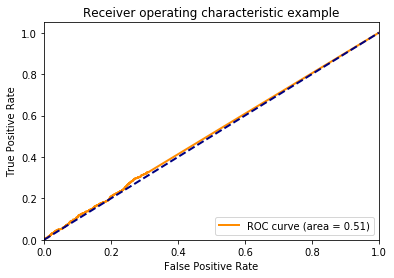

0.5080340191121904

In [99]:
model = train_model(model,X_train,y_train,X_test,y_test,
                    TRAINING_EPOCH=10,BATCH_SIZE=128,PLOT=False)
y_pred = model.predict(X_test).reshape(-1)
AUC = evaluate_model(y_test,y_pred)
AUC

tweedie loss

In [123]:

#For instance, p=1 links to Poisson distribution,
#p=3 links to inverse Gaussian distribution, 
#p∈ (1, 2) links to compound Poisson-gamma distribution.


# Loss = -y_true * y_pred^(1-p)/(1-p) + y_pred^(2-p)/(2-p)
# this version is not robust for y_pred < 0
def tweedie_loss_func(p):
    def tweedie_loglikelihood(y_true, y_pred):
        loss = - y_true * K.pow(y_pred, 1 - p) / (1 - p) + \
               K.pow(y_pred, 2 - p) / (2 - p)
        return K.mean(loss)
    return tweedie_loglikelihood


# Loss = exp(y_pred(1-p))*(exp(x)/(2-p)+y_true/(p-1))
# this version is robust, even for y_pred>0

def tweedie_loss_func(p):
    def tweedie_loglikelihood(y_true, y_pred):
        loss = K.exp(y_pred*(1-p))*(K.exp(y_pred)/(2-p)+y_true/(p-1))
        
        return K.mean(loss)
    return tweedie_loglikelihood
    

Train on 7000 samples, validate on 3000 samples
Epoch 1/10
7000/7000 [==============================] - 2s 337us/sample - loss: 3.3538 - val_loss: 3.3457
Epoch 2/10
7000/7000 [==============================] - 1s 95us/sample - loss: 3.3337 - val_loss: 3.3324
Epoch 3/10
7000/7000 [==============================] - 1s 111us/sample - loss: 3.3219 - val_loss: 3.3204
Epoch 4/10
7000/7000 [==============================] - 1s 105us/sample - loss: 3.3105 - val_loss: 3.3089
Epoch 5/10
7000/7000 [==============================] - 1s 102us/sample - loss: 3.2993 - val_loss: 3.2978
Epoch 6/10
7000/7000 [==============================] - 1s 107us/sample - loss: 3.2885 - val_loss: 3.2871
Epoch 7/10
7000/7000 [==============================] - 1s 98us/sample - loss: 3.2780 - val_loss: 3.2767
Epoch 8/10
7000/7000 [==============================] - 1s 95us/sample - loss: 3.2678 - val_loss: 3.2667
Epoch 9/10
7000/7000 [==============================] - 1s 117us/sample - loss: 3.2579 - val_loss: 3.2570
E

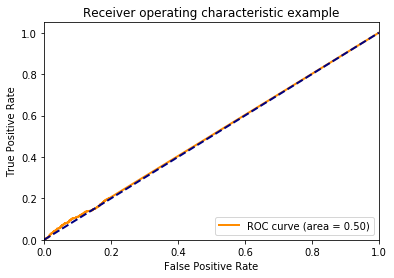

0.5040181795957372

In [124]:
adam = keras.optimizers.Adam(lr=0.001)
p = 1.5

Loss = tweedie_loss_func(p)

trend_model = build_trend_model([1,10,1],5,[1])
seasonal_model = build_seasonal_model([1,10,1],5,[1])
wide_model = build_wide_model([10,1])
wide_model_with_embeddings = build_wide_model_with_embeddings([10,5,1],[10,5])

model = merge_model(trend_model,seasonal_model,wide_model_with_embeddings)
model = train_model(model,X_train,y_train,X_test,y_test,
                    TRAINING_EPOCH=10,BATCH_SIZE=128,PLOT=False)
y_pred = model.predict(X_test).reshape(-1)
AUC = evaluate_model(y_test,y_pred)
AUC

# Bayesian Optimization

As you see, the example model above is so complicated! <br>
For simplicity, I provided a simple version of model here.

In [105]:
def build_trend_model(filters,lstm_output,dense_outputs):
   
    #trend model
    trend_input  = layers.Input(shape=len(trend_features),name='trend_input')
    trend_output = SimpleConv_Block(trend_input,filters)
    trend_output = LSTM_Block(trend_output,lstm_output)
    trend_output = Dense_Block(trend_output,dense_outputs)
    
    model = keras.Model(inputs=trend_input,outputs=trend_output)
    model.compile(loss=Loss,optimizers=adam)
    return model


def build_wide_model(dense_outputs):
    wide_input  = layers.Input(shape=len(wide_features),name='wide_input')
    
    wide_output = Dense_Block(wide_input,dense_outputs)
    model = keras.Model(inputs=wide_input,outputs=wide_output)
    model.compile(loss=Loss,optimizers=adam)
    
    return model

def merge_model(trend_model,wide_model):
    merged_output = layers.concatenate([trend_model.output,wide_model.output,])
    merged_output = layers.Dense(1,activation='sigmoid')(merged_output)
    merged_model = keras.Model([trend_model.input] + [wide_model.input], merged_output)
    merged_model.compile(loss=Loss, optimizer=adam)
    
    return merged_model 
    
    

filters = Integer(low=1, high=5, name='filters')
lstm_output = Integer(low=1,high=10,name="lstm_output")
dense_outputs_trend = Integer(low=1, high=10, name='dense_outputs_trend')
dense_outputs_wide = Integer(low=1, high=10, name='dense_outputs_wide')
loss = Categorical(['binary_crossentropy',tweedie_loss_func(1.5),binary_focal_loss(alpha1,alpha2,gamma1,gamma2)],name='objective')
lr = Real(low=1e-4,high=1e-1,name="lr")
TRAINING_EPOCH = Integer(low=1, high=20, name='TRAINING_EPOCH')

BATCH_SIZE = Categorical([64,128,256,512,1024],name='BATCH_SIZE')


dimensions = [
    filters,
    lstm_output,
    dense_outputs_trend,
    dense_outputs_wide,
    loss,
    lr,
    TRAINING_EPOCH,
    BATCH_SIZE  
]


   
X_train = [X_train_trend] +  [X_train_wide] 
X_test  = [X_test_trend] +  [X_test_wide] 



In [106]:
def fitness(dimensions):    
    adam = keras.optimizers.Adam(lr=dimensions[5])
    Loss = dimensions[4]
    trend_model = build_trend_model(dimensions[0],dimensions[1],[dimensions[2]])
    wide_model = build_wide_model([dimensions[3]])
    model = merge_model(trend_model,wide_model)
    model = train_model(model,X_train,y_train,X_test,y_test,
                        TRAINING_EPOCH=dimensions[6],BATCH_SIZE=dimensions[7],PLOT=False)
    y_pred = model.predict(X_test).reshape(-1)
    AUC = evaluate_model(y_test,y_pred)
    return round(AUC,4)

In [121]:
    
default_parameters = [2,5,5,5,'binary_crossentropy',0.01,2,128]
gp_result = gp_minimize(func=fitness,dimensions=dimensions,verbose=True,n_jobs=4,n_calls=11,x0=default_parameters)
params = []
params.append(gp_result.x)